**Flow:**



*   Download dataset from G-Drive
*   Pre-processing: duplicate and null check
*   EDA:
> understand relation - univariate, bivariate, correlation -- charts

*   Model Building / Predictive Analysis:

> Data transform: delete columns like ID, batch etc after EDA

> SPSS: analysis for PCA, which columns can be removed

> Model Iter - 1: Test few models with all columns:
different set of columns and compare with all columns; which gives better results

> Model Iter - 2: Test again after removing some columns with less Eigen values suggested by SPSS

> Model Iter - 3: Test again after removing few more columns

> Compare Iter 1, 2 & 3:
as no model is giving some significant results, use resampling and try again

> Model Training with Resampling

> Hyperparameter tuning for best model from resampling:
Model which are giving better results with resampling, try to tune hyperparameters for optimum performance

> Try scaling on best model with resampling and tuned hyperparameter
try scaling for columns with large variance and conclude whether scaling is useful or not


##Download Dataset

In [ ]:
#download dataset
!gdown '1SCWj_Nqql59TOgSZKoSkS9Y5jLJZOSk2'

Downloading...
From: https://drive.google.com/uc?id=1SCWj_Nqql59TOgSZKoSkS9Y5jLJZOSk2
To: /content/loan default prediction_train.csv
100% 17.3M/17.3M [00:00<00:00, 89.7MB/s]


##Libraries

In [ ]:
#library functions to be used
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.linear_model  import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.metrics import log_loss, f1_score, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import imblearn
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

##Preprocessing

In [ ]:
#loading dataset to dataframe
train_df = pd.read_csv('loan default prediction_train.csv')
train_df.head(2)

ID  Loan Amount  Funded Amount  Funded Amount Investor  Term  \
0  65087372        10000          32236             12329.36286    59   
1   1450153         3609          11940             12191.99692    59   

  Batch Enrolled  Interest Rate Grade Sub Grade Employment Duration  ...  \
0     BAT2522922      11.135007     B        C4            MORTGAGE  ...   
1     BAT1586599      12.237563     C        D3                RENT  ...   

   Recoveries Collection Recovery Fee Collection 12 months Medical  \
0    2.498291                0.793724                            0   
1    2.377215                0.974821                            0   

  Application Type  Last week Pay  Accounts Delinquent  \
0       INDIVIDUAL             49                    0   
1       INDIVIDUAL            109                    0   

   Total Collection Amount  Total Current Balance  \
0                       31                 311301   
1                       53                 182610   

   Total Revolving Credit Limit  Loan Status  
0                          6619            0  
1                         20885            0  

[2 rows x 35 columns]

In [ ]:
#checking distinct classes with count
train_df['Loan Status'].value_counts()

0    61222
1     6241
Name: Loan Status, dtype: int64

In [ ]:
#checking duplicates
train_df.duplicated().sum()

0

In [ ]:
#checking null
train_df.isna().sum()

ID                              0
Loan Amount                     0
Funded Amount                   0
Funded Amount Investor          0
Term                            0
Batch Enrolled                  0
Interest Rate                   0
Grade                           0
Sub Grade                       0
Employment Duration             0
Home Ownership                  0
Verification Status             0
Payment Plan                    0
Loan Title                      0
Debit to Income                 0
Delinquency - two years         0
Inquires - six months           0
Open Account                    0
Public Record                   0
Revolving Balance               0
Revolving Utilities             0
Total Accounts                  0
Initial List Status             0
Total Received Interest         0
Total Received Late Fee         0
Recoveries                      0
Collection Recovery Fee         0
Collection 12 months Medical    0
Application Type                0
Last week Pay 

##EDA

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Employment Duration           67463 non-null  object 
 10  Home Ownership                67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

In [ ]:
train_df.describe()

ID   Loan Amount  Funded Amount  Funded Amount Investor  \
count  6.746300e+04  67463.000000   67463.000000            67463.000000   
mean   2.562761e+07  16848.902776   15770.599114            14621.799323   
std    2.109155e+07   8367.865726    8150.992662             6785.345170   
min    1.297933e+06   1014.000000    1014.000000             1114.590204   
25%    6.570288e+06  10012.000000    9266.500000             9831.684984   
50%    1.791565e+07  16073.000000   13042.000000            12793.682170   
75%    4.271521e+07  22106.000000   21793.000000            17807.594120   
max    7.224578e+07  35000.000000   34999.000000            34999.746430   

               Term  Interest Rate  Home Ownership  Debit to Income  \
count  67463.000000   67463.000000    67463.000000     67463.000000   
mean      58.173814      11.846258    80541.502522        23.299241   
std        3.327441       3.718629    45029.120366         8.451824   
min       36.000000       5.320006    14573.537170         0.675299   
25%       58.000000       9.297147    51689.843335        16.756416   
50%       59.000000      11.377696    69335.832680        22.656658   
75%       59.000000      14.193533    94623.322785        30.048400   
max       59.000000      27.182348   406561.536400        39.629862   

       Delinquency - two years  Inquires - six months  ...  \
count             67463.000000           67463.000000  ...   
mean                  0.327127               0.145754  ...   
std                   0.800888               0.473291  ...   
min                   0.000000               0.000000  ...   
25%                   0.000000               0.000000  ...   
50%                   0.000000               0.000000  ...   
75%                   0.000000               0.000000  ...   
max                   8.000000               5.000000  ...   

       Total Received Late Fee    Recoveries  Collection Recovery Fee  \
count             67463.000000  67463.000000             67463.000000   
mean                  1.143969     59.691578                 1.125141   
std                   5.244365    357.026346                 3.489885   
min                   0.000003      0.000036                 0.000036   
25%                   0.021114      1.629818                 0.476259   
50%                   0.043398      3.344524                 0.780141   
75%                   0.071884      5.453727                 1.070566   
max                  42.618882   4354.467419               166.833000   

       Collection 12 months Medical  Last week Pay  Accounts Delinquent  \
count                  67463.000000   67463.000000              67463.0   
mean                       0.021301      71.163260                  0.0   
std                        0.144385      43.315845                  0.0   
min                        0.000000       0.000000                  0.0   
25%                        0.000000      35.000000                  0.0   
50%                        0.000000      68.000000                  0.0   
75%                        0.000000     105.000000                  0.0   
max                        1.000000     161.000000                  0.0   

       Total Collection Amount  Total Current Balance  \
count             67463.000000           6.746300e+04   
mean                146.467990           1.595739e+05   
std                 744.382233           1.390332e+05   
min                   1.000000           6.170000e+02   
25%                  24.000000           5.037900e+04   
50%                  36.000000           1.183690e+05   
75%                  46.000000           2.283750e+05   
max               16421.000000           1.177412e+06   

       Total Revolving Credit Limit   Loan Status  
count                  67463.000000  67463.000000  
mean                   23123.005544      0.092510  
std                    20916.699999      0.289747  
min                     1000.000000      0.000000  
25%                     8

###Dividing into Categorical and Numerical columns

In [ ]:
#categorical column names and count
categorical_columns = [i for i in train_df.select_dtypes(include='object').columns]
print(f'Categorical Column Names: {categorical_columns}')
print(f'#Categorical Columns: {len(categorical_columns)}')

Categorical Column Names: ['Batch Enrolled', 'Grade', 'Sub Grade', 'Employment Duration', 'Verification Status', 'Payment Plan', 'Loan Title', 'Initial List Status', 'Application Type']
#Categorical Columns: 9


In [ ]:
#unique values in categorical columns
for i in categorical_columns:
    print("The no.of unique values in",i,"are: ",train_df.loc[:,i].nunique())

The no.of unique values in Batch Enrolled are:  41
The no.of unique values in Grade are:  7
The no.of unique values in Sub Grade are:  35
The no.of unique values in Employment Duration are:  3
The no.of unique values in Verification Status are:  3
The no.of unique values in Payment Plan are:  1
The no.of unique values in Loan Title are:  109
The no.of unique values in Initial List Status are:  2
The no.of unique values in Application Type are:  2


'Grade', 'Employment Duration', 'Verification Status', 'Initial List Status' and 'Application Type' have less distinct values and one hot encoding can be used for these columns.


'Batch Enrolled', 'Sub Grade', 'Loan Title' have high distinct values as  41, 35 and 109. One hot encoding will increase #columns drastically for these features. Must find a way to handle these values.

'Payment Plan' just has 1 value hence can be dropped as a feature for model training.

Batch Enrolled: BAT3873588    3626
BAT1586599    3142
BAT1104812    2996
BAT2252229    2557
BAT2803411    2425
BAT1780517    2403
BAT1184694    2298
BAT2078974    2290
BAT2575549    2257
BAT4694572    2248
BAT4271519    2054
BAT2558388    1963
BAT3193689    1864
BAT1930365    1844
BAT2136391    1790
BAT2333412    1775
BAT3726927    1774
BAT4136152    1766
BAT5341619    1717
BAT5525466    1709
BAT5489674    1677
BAT5629144    1639
BAT1766061    1461
BAT2833642    1421
BAT5924421    1404
BAT2522922    1399
BAT2428731    1398
BAT4808022    1303
BAT4351734    1140
BAT5547201    1127
BAT5714674    1105
BAT3461431    1068
BAT224923      895
BAT1761981     894
BAT4722912     887
BAT2003848     842
BAT1467036     802
BAT5849876     768
BAT3865626     728
BAT5811547     711
BAT1135695     296
Name: Batch Enrolled, dtype: int64


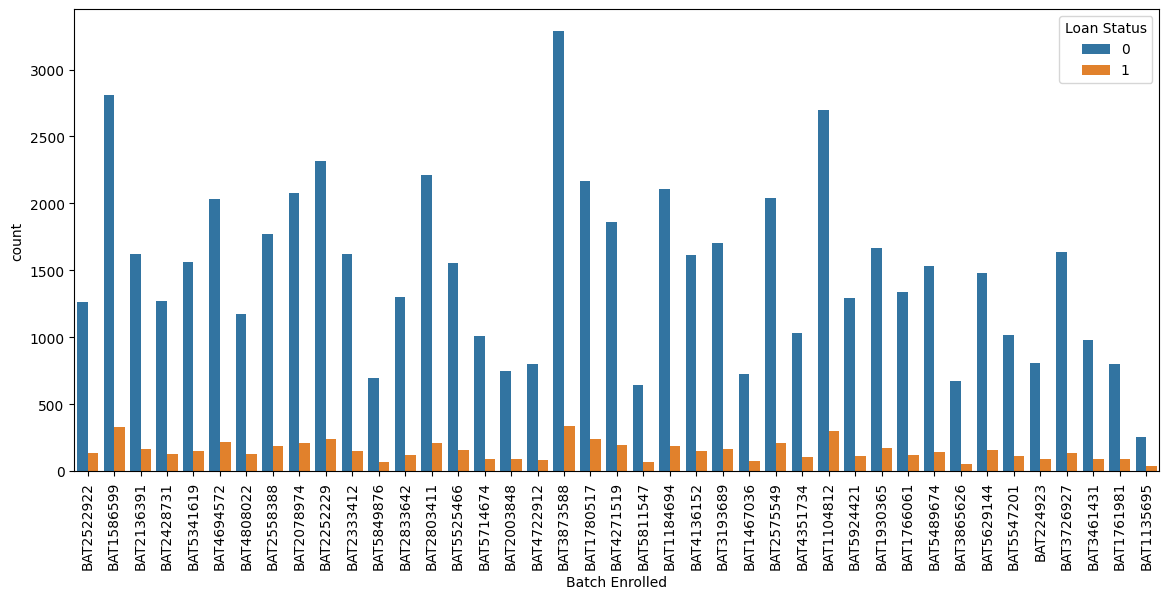




Grade: C    19085
B    18742
A    12055
D     8259
E     6446
F     2246
G      630
Name: Grade, dtype: int64


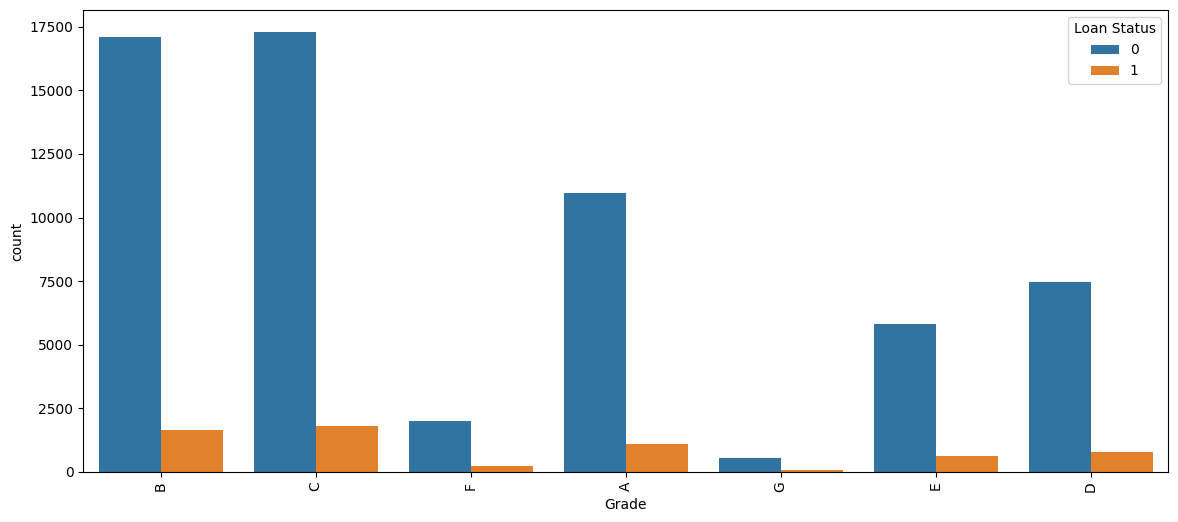




Sub Grade: B4    4462
C1    4188
B3    3999
A5    3540
B2    3520
B5    3408
D1    3304
C4    3250
C2    3219
C3    3121
B1    2924
C5    2472
A4    2264
D4    2050
D2    1963
D5    1952
A2    1837
D3    1824
E2    1746
A3    1685
A1    1364
E3    1321
E1    1298
E4    1117
F2     947
F1     824
E5     769
F5     582
F3     578
G2     447
F4     441
G1     366
G5     284
G3     246
G4     151
Name: Sub Grade, dtype: int64


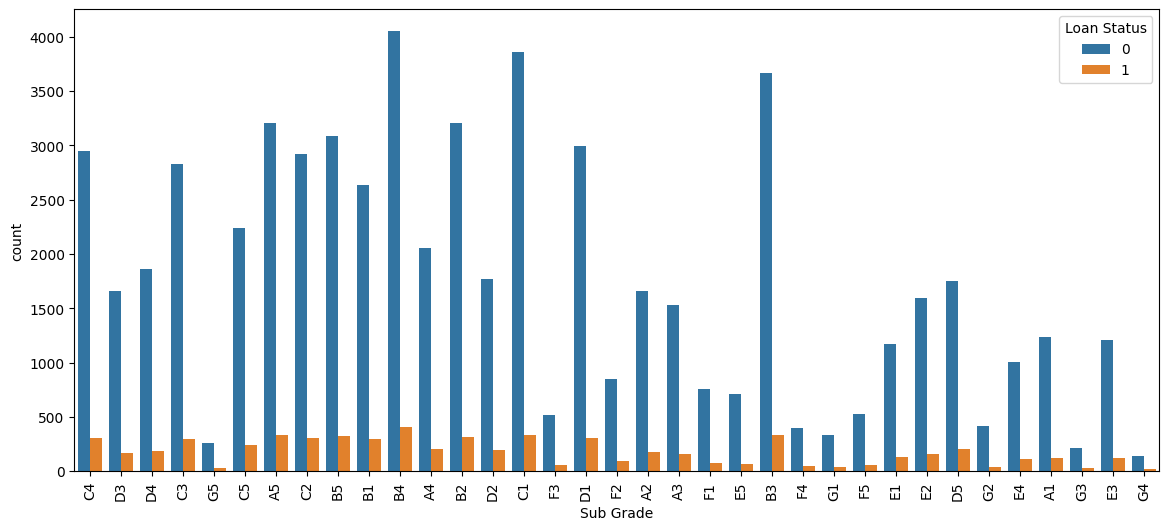




Employment Duration: MORTGAGE    36351
RENT        24150
OWN          6962
Name: Employment Duration, dtype: int64


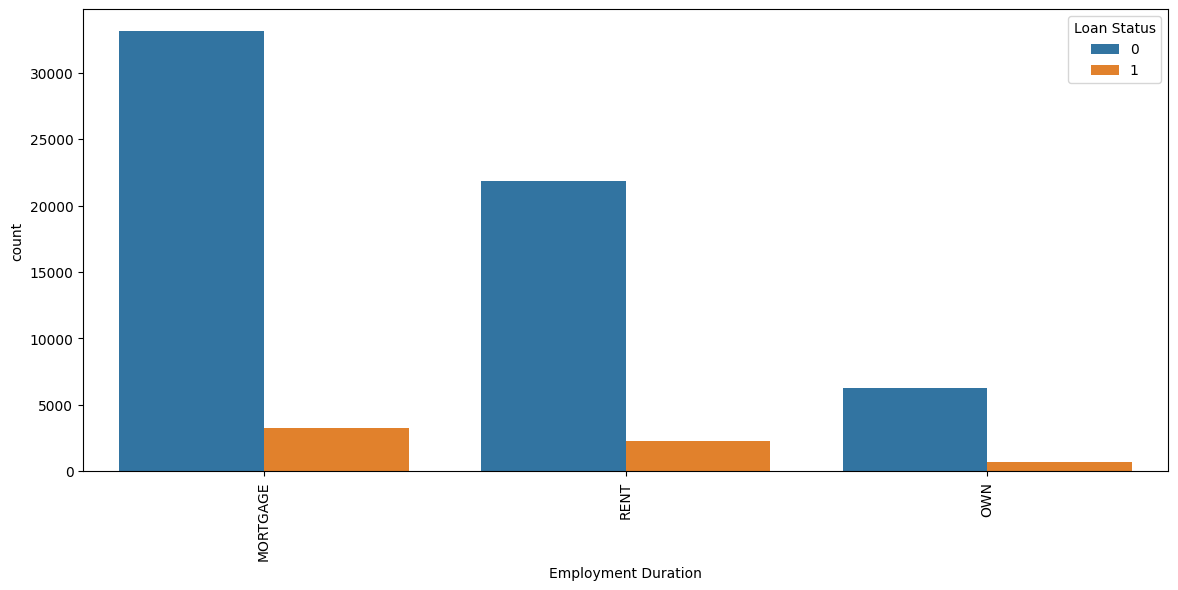




Verification Status: Source Verified    33036
Verified           18078
Not Verified       16349
Name: Verification Status, dtype: int64


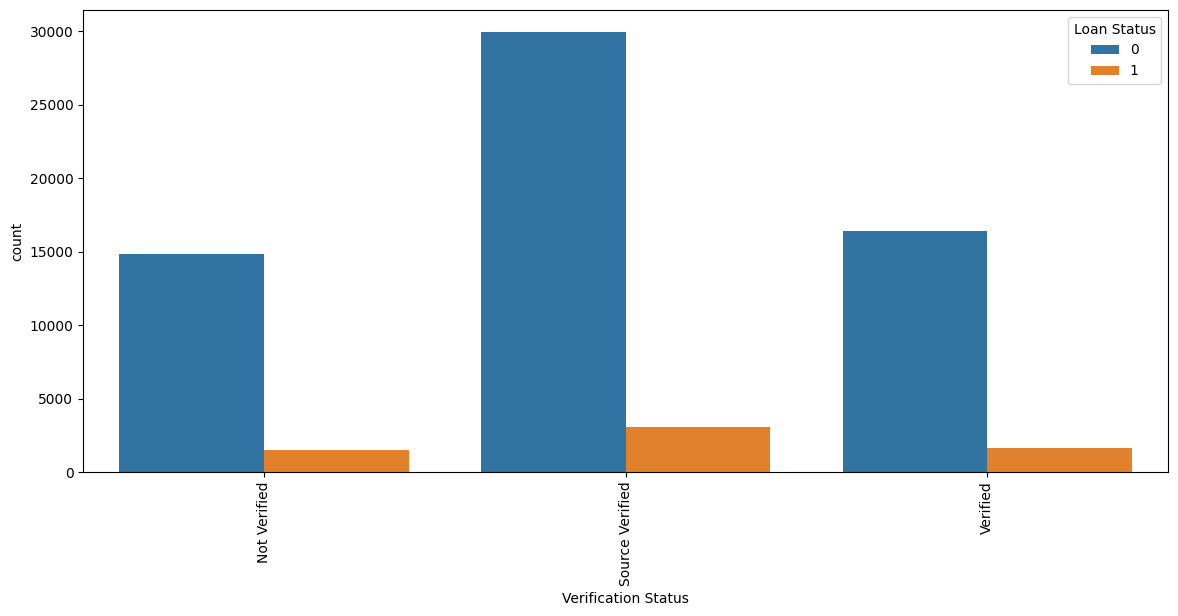




Payment Plan: n    67463
Name: Payment Plan, dtype: int64


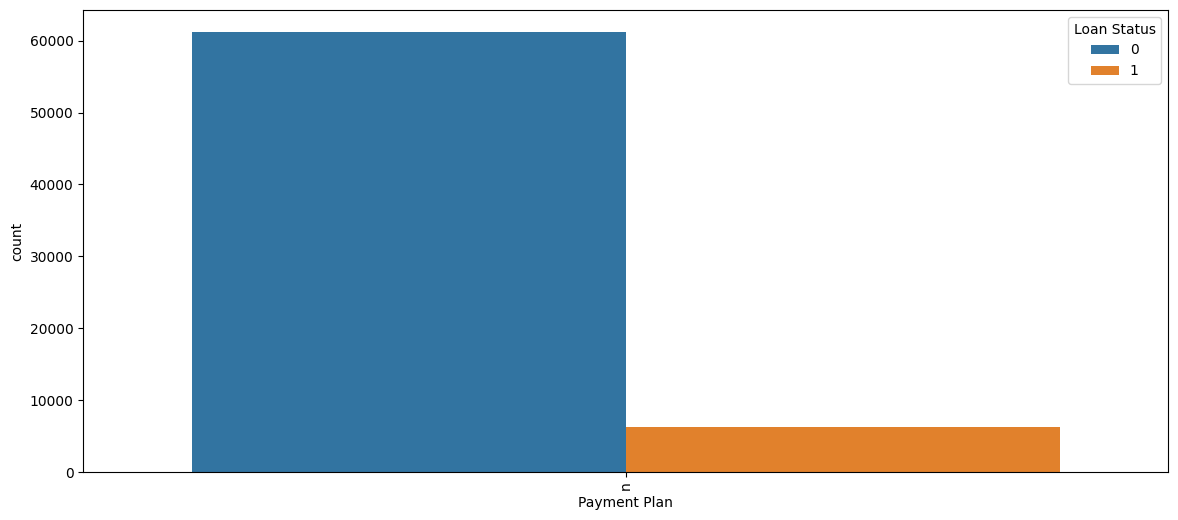




Loan Title: Credit card refinancing    30728
Debt consolidation         24841
Debt Consolidation          3544
Other                       2455
Home improvement            2211
                           ...  
Home loan                      6
Personal loan                  5
Getting Ahead                  5
Credit                         4
bills                          4
Name: Loan Title, Length: 109, dtype: int64


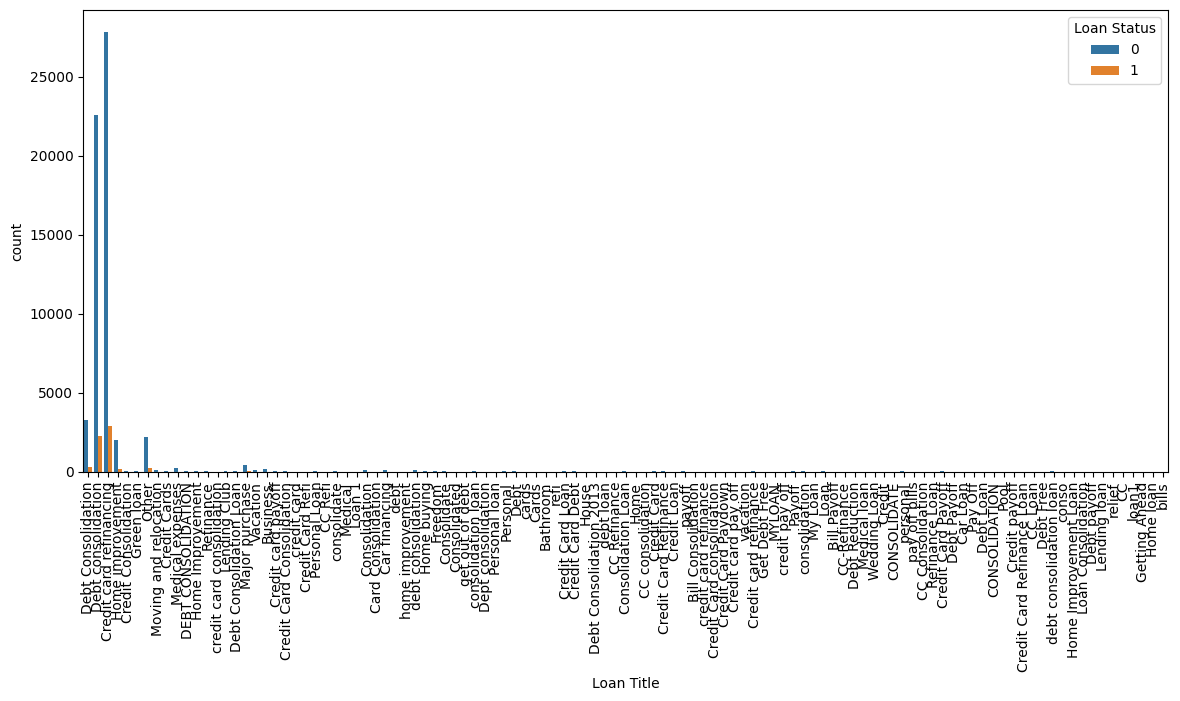




Initial List Status: w    36299
f    31164
Name: Initial List Status, dtype: int64


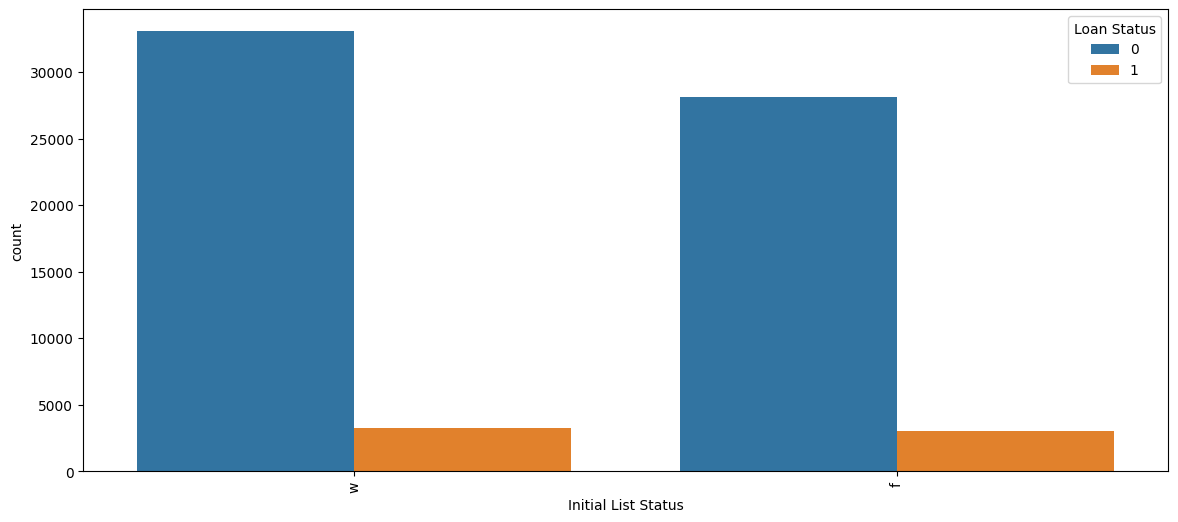




Application Type: INDIVIDUAL    67340
JOINT           123
Name: Application Type, dtype: int64


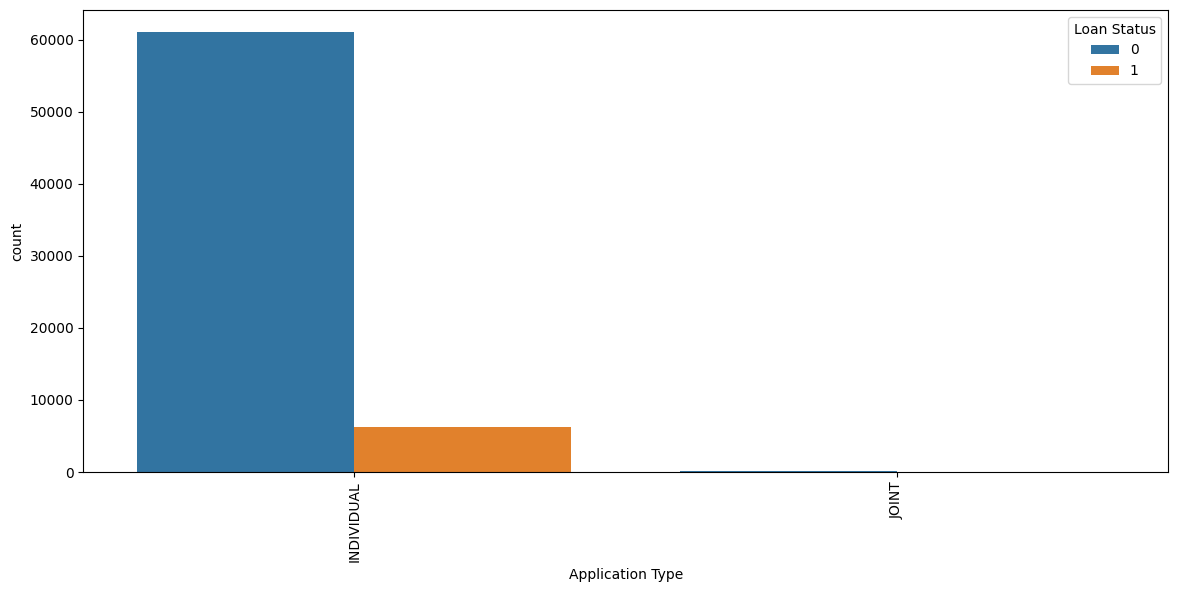

In [ ]:
#visual analysis on categorical columns
for col_name in categorical_columns:
  print(f'{col_name}: {train_df[col_name].value_counts()}')
  plt.figure(figsize=(14,6))
  plt.xticks(rotation=90)
  sns.countplot(data=train_df,x=col_name,hue='Loan Status')
  plt.show()
  print('\n\n')

In [ ]:
#numerical columns and their counts
numeric_columns = [i for i in train_df.select_dtypes(exclude='object').columns]

print(f'Numerical Column Names: {numeric_columns}')
print(f'#Numerical Columns: {len(numeric_columns)}')

Numerical Column Names: ['ID', 'Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term', 'Interest Rate', 'Home Ownership', 'Debit to Income', 'Delinquency - two years', 'Inquires - six months', 'Open Account', 'Public Record', 'Revolving Balance', 'Revolving Utilities', 'Total Accounts', 'Total Received Interest', 'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee', 'Collection 12 months Medical', 'Last week Pay', 'Accounts Delinquent', 'Total Collection Amount', 'Total Current Balance', 'Total Revolving Credit Limit', 'Loan Status']
#Numerical Columns: 26


In [ ]:
#unique values in numerical columns
for i in numeric_columns:
    print("The no.of unique values in",i,"are: ",train_df.loc[:,i].nunique())

The no.of unique values in ID are:  67463
The no.of unique values in Loan Amount are:  27525
The no.of unique values in Funded Amount are:  24548
The no.of unique values in Funded Amount Investor are:  67441
The no.of unique values in Term are:  3
The no.of unique values in Interest Rate are:  67448
The no.of unique values in Home Ownership are:  67454
The no.of unique values in Debit to Income are:  67454
The no.of unique values in Delinquency - two years are:  9
The no.of unique values in Inquires - six months are:  6
The no.of unique values in Open Account are:  36
The no.of unique values in Public Record are:  5
The no.of unique values in Revolving Balance are:  20582
The no.of unique values in Revolving Utilities are:  67458
The no.of unique values in Total Accounts are:  69
The no.of unique values in Total Received Interest are:  67451
The no.of unique values in Total Received Late Fee are:  67380
The no.of unique values in Recoveries are:  67387
The no.of unique values in Collec

'ID' feature has all unique values, either we can convert this to index or can drop this feature.

'Accounts Delinquent' just have one value, hence, can be dropped.

Rest columns which have large numerical values like loan amount can be scaled.

###Univariate Analysis

Term: 59    43780
58    22226
36     1457
Name: Term, dtype: int64


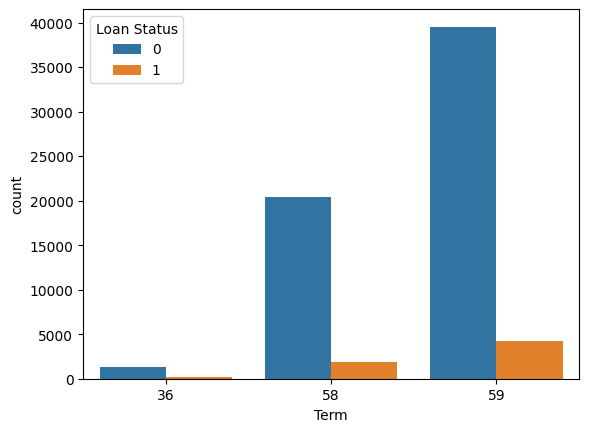



Delinquency - two years: 0    52054
1    11736
2     2651
3      445
7      252
6      191
5       74
8       44
4       16
Name: Delinquency - two years, dtype: int64


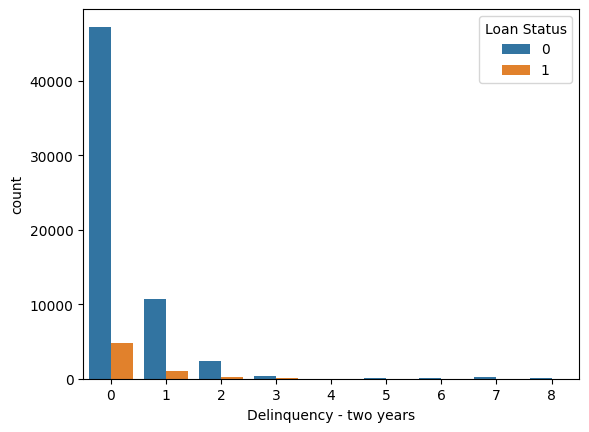



Inquires - six months: 0    60486
1     4558
2     2042
3      320
4       54
5        3
Name: Inquires - six months, dtype: int64


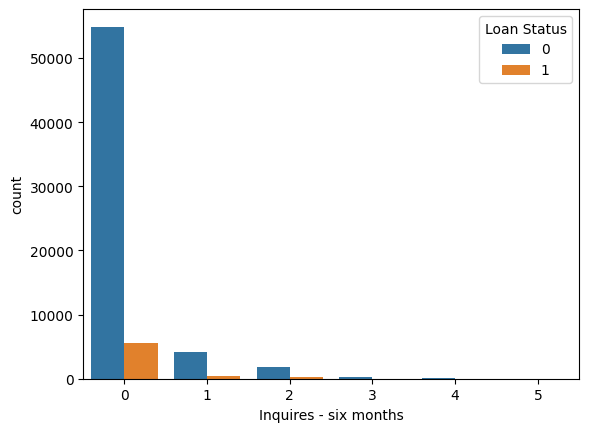



Public Record: 0    62871
1     4133
2      200
4      184
3       75
Name: Public Record, dtype: int64


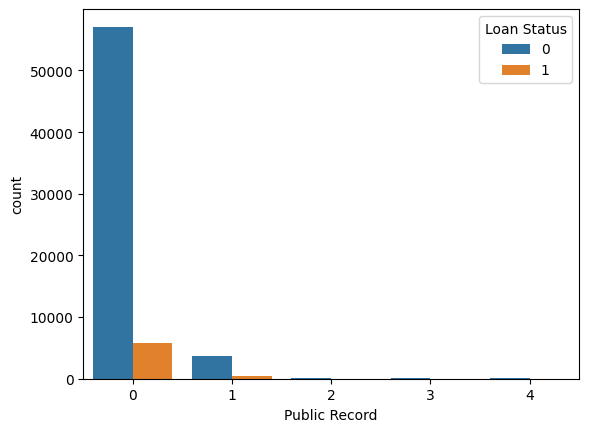



Collection 12 months Medical: 0    66026
1     1437
Name: Collection 12 months Medical, dtype: int64


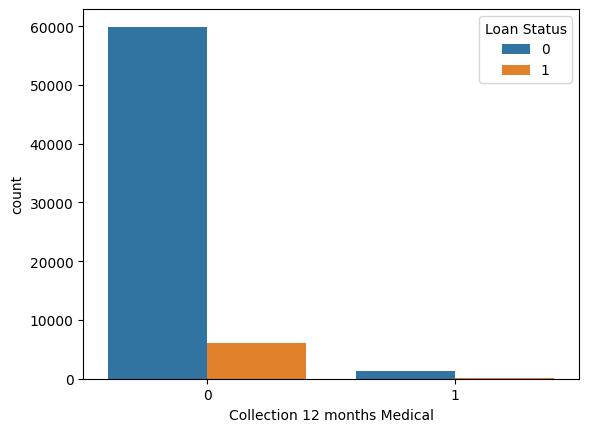

In [ ]:
#checking numeric values with less cardinality: 'Term', 'Delinquency - two years', 'Inquires - six months', 'Public Record', 'Collection 12 months Medical'

print(f'Term: {train_df["Term"].value_counts()}')
sns.countplot(data=train_df,x='Term',hue='Loan Status')
plt.show()

print(f'\n\nDelinquency - two years: {train_df["Delinquency - two years"].value_counts()}')
sns.countplot(data=train_df,x='Delinquency - two years',hue='Loan Status')
plt.show()

print(f'\n\nInquires - six months: {train_df["Inquires - six months"].value_counts()}')
sns.countplot(data=train_df,x='Inquires - six months',hue='Loan Status')
plt.show()

print(f'\n\nPublic Record: {train_df["Public Record"].value_counts()}')
sns.countplot(data=train_df,x='Public Record',hue='Loan Status')
plt.show()

print(f'\n\nCollection 12 months Medical: {train_df["Collection 12 months Medical"].value_counts()}')
sns.countplot(data=train_df,x='Collection 12 months Medical',hue='Loan Status')
plt.show()

In [ ]:
#column has only one value
train_df['Accounts Delinquent'].value_counts()

0    67463
Name: Accounts Delinquent, dtype: int64

In [ ]:
#removing 'Term', 'Delinquency - two years', 'Inquires - six months', 'Public Record', 'Collection 12 months Medical' from numerical cols
#also removing 'Accounts Delinquent' as it just has 1 value; Dependent variable: 'Loan Status'
##num_cols = ['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Interest Rate', 'Home Ownership', 'Debit to Income', 'Total Accounts']

#finalizing numeric columns (18)
num_cols = ['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Interest Rate', 'Home Ownership', 'Debit to Income', 'Open Account', 'Revolving Balance', 'Revolving Utilities', 'Total Accounts', 'Total Received Interest', 'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee', 'Last week Pay', 'Total Collection Amount', 'Total Current Balance', 'Total Revolving Credit Limit']

len(num_cols)

18

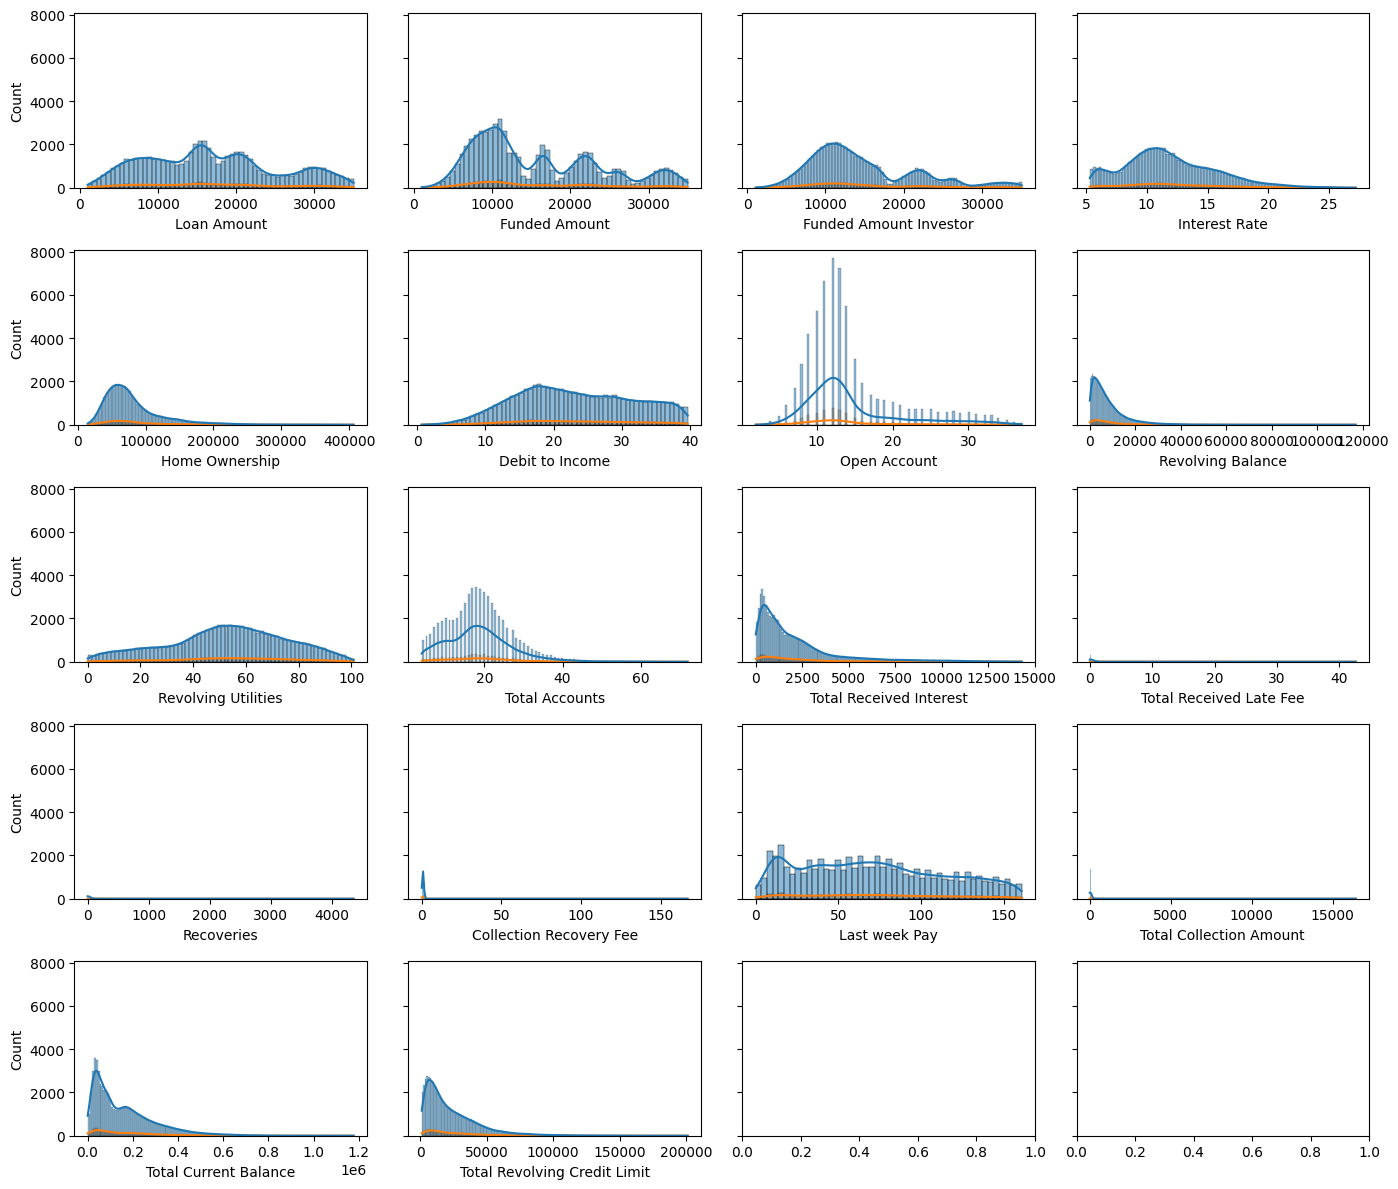

In [ ]:
#plotting in sub-plots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 12), sharex=False, sharey=True)
axes = axes.ravel()
i = 0

for col_name in num_cols:
  sns.histplot(data=train_df, x=col_name, kde=True, hue='Loan Status', ax=axes[i], legend=False)
  i+=1

fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Loan Amount vs Interest Rate by Loan Status')

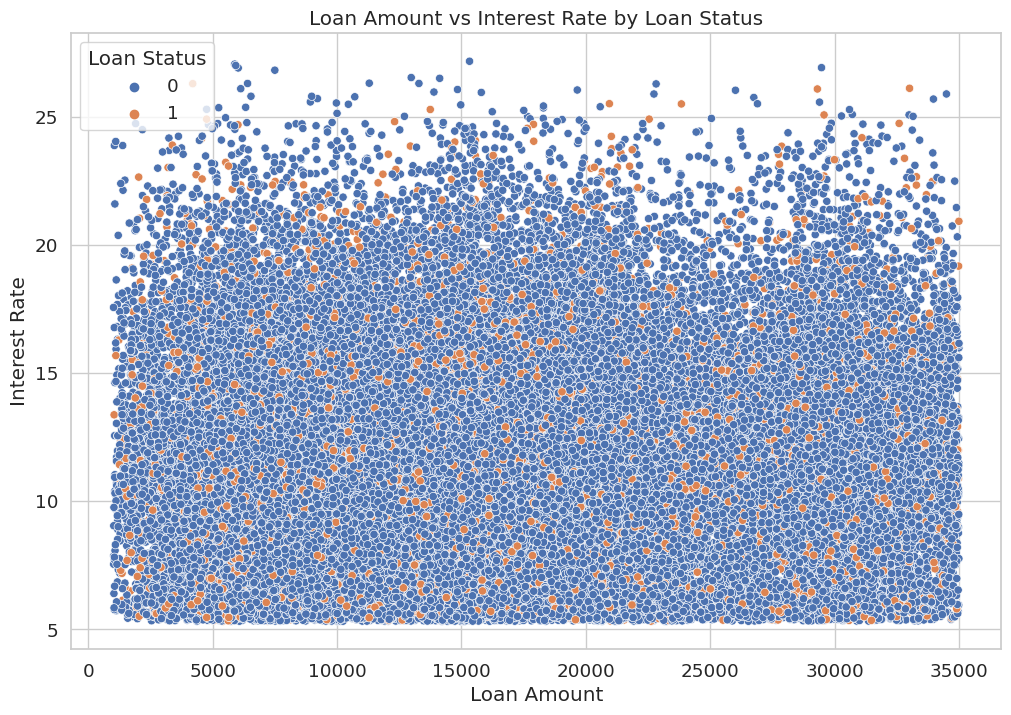

In [ ]:
#scatter plot for bivariate analysis
#set up the figure
sns.set(style="whitegrid", font_scale=1.2)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

#create the visualization
sns.scatterplot(x="Loan Amount", y="Interest Rate", hue="Loan Status", data=train_df, ax=ax)

#set the labels and title
ax.set_xlabel("Loan Amount")
ax.set_ylabel("Interest Rate")
ax.set_title("Loan Amount vs Interest Rate by Loan Status")

###Multivariate Analysis

In [ ]:
train_df.columns

Index(['ID', 'Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term',
       'Batch Enrolled', 'Interest Rate', 'Grade', 'Sub Grade',
       'Employment Duration', 'Home Ownership', 'Verification Status',
       'Payment Plan', 'Loan Title', 'Debit to Income',
       'Delinquency - two years', 'Inquires - six months', 'Open Account',
       'Public Record', 'Revolving Balance', 'Revolving Utilities',
       'Total Accounts', 'Initial List Status', 'Total Received Interest',
       'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee',
       'Collection 12 months Medical', 'Application Type', 'Last week Pay',
       'Accounts Delinquent', 'Total Collection Amount',
       'Total Current Balance', 'Total Revolving Credit Limit', 'Loan Status'],
      dtype='object')

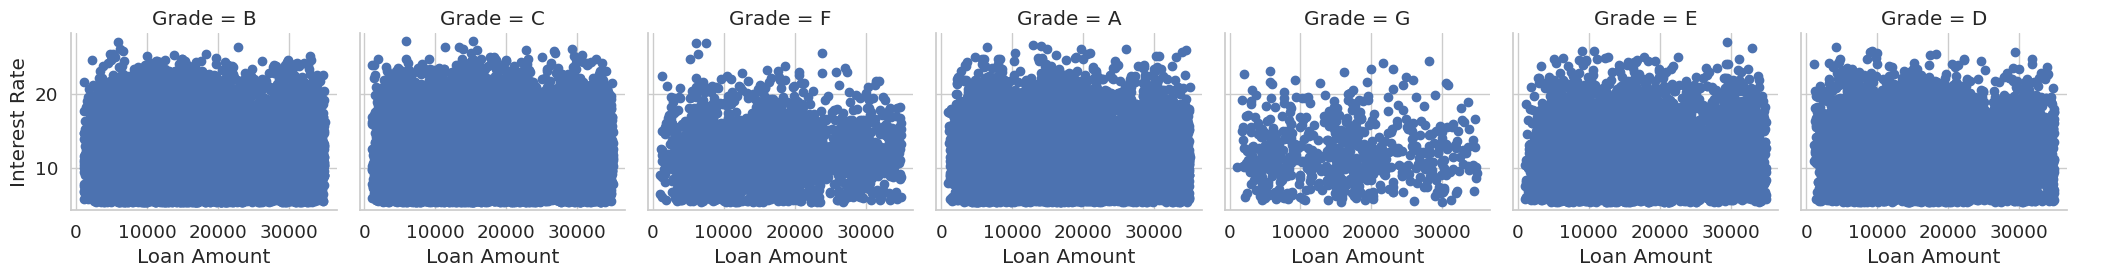

In [ ]:
#multivariate analysis between different columns
sns.FacetGrid(data = train_df, col = 'Grade').map(plt.scatter, 'Loan Amount', 'Interest Rate').add_legend()
plt.show()

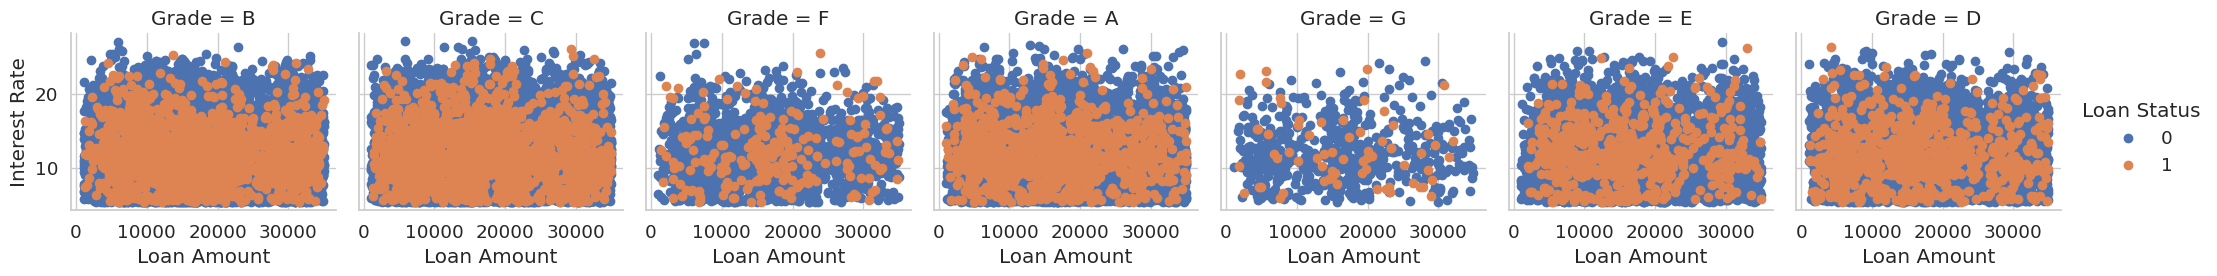

In [ ]:
sns.FacetGrid(data = train_df, col = 'Grade', hue='Loan Status').map(plt.scatter, 'Loan Amount', 'Interest Rate').add_legend()
plt.show()

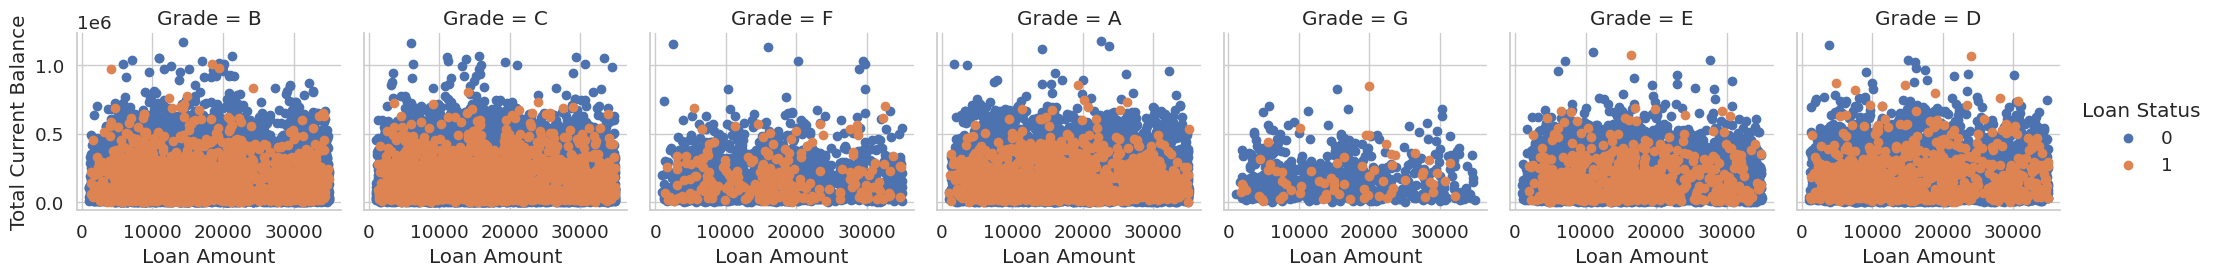

In [ ]:
#train_df[''].value_counts()
sns.FacetGrid(data = train_df, col = 'Grade', hue='Loan Status').map(plt.scatter, 'Loan Amount', 'Total Current Balance').add_legend()
plt.show()

<Figure size 1200x800 with 0 Axes>

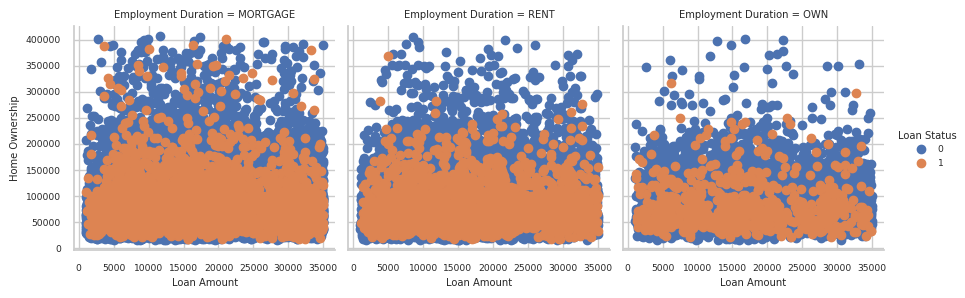

In [ ]:
sns.set(style="whitegrid", font_scale=.6)
fig = plt.figure(figsize=(12, 8))
sns.FacetGrid(data = train_df, col = 'Employment Duration', hue='Loan Status').map(plt.scatter, 'Loan Amount', 'Home Ownership').add_legend()


plt.show()


###Correlation

<ipython-input-24-cbae18087f8d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df.corr()


<Axes: >

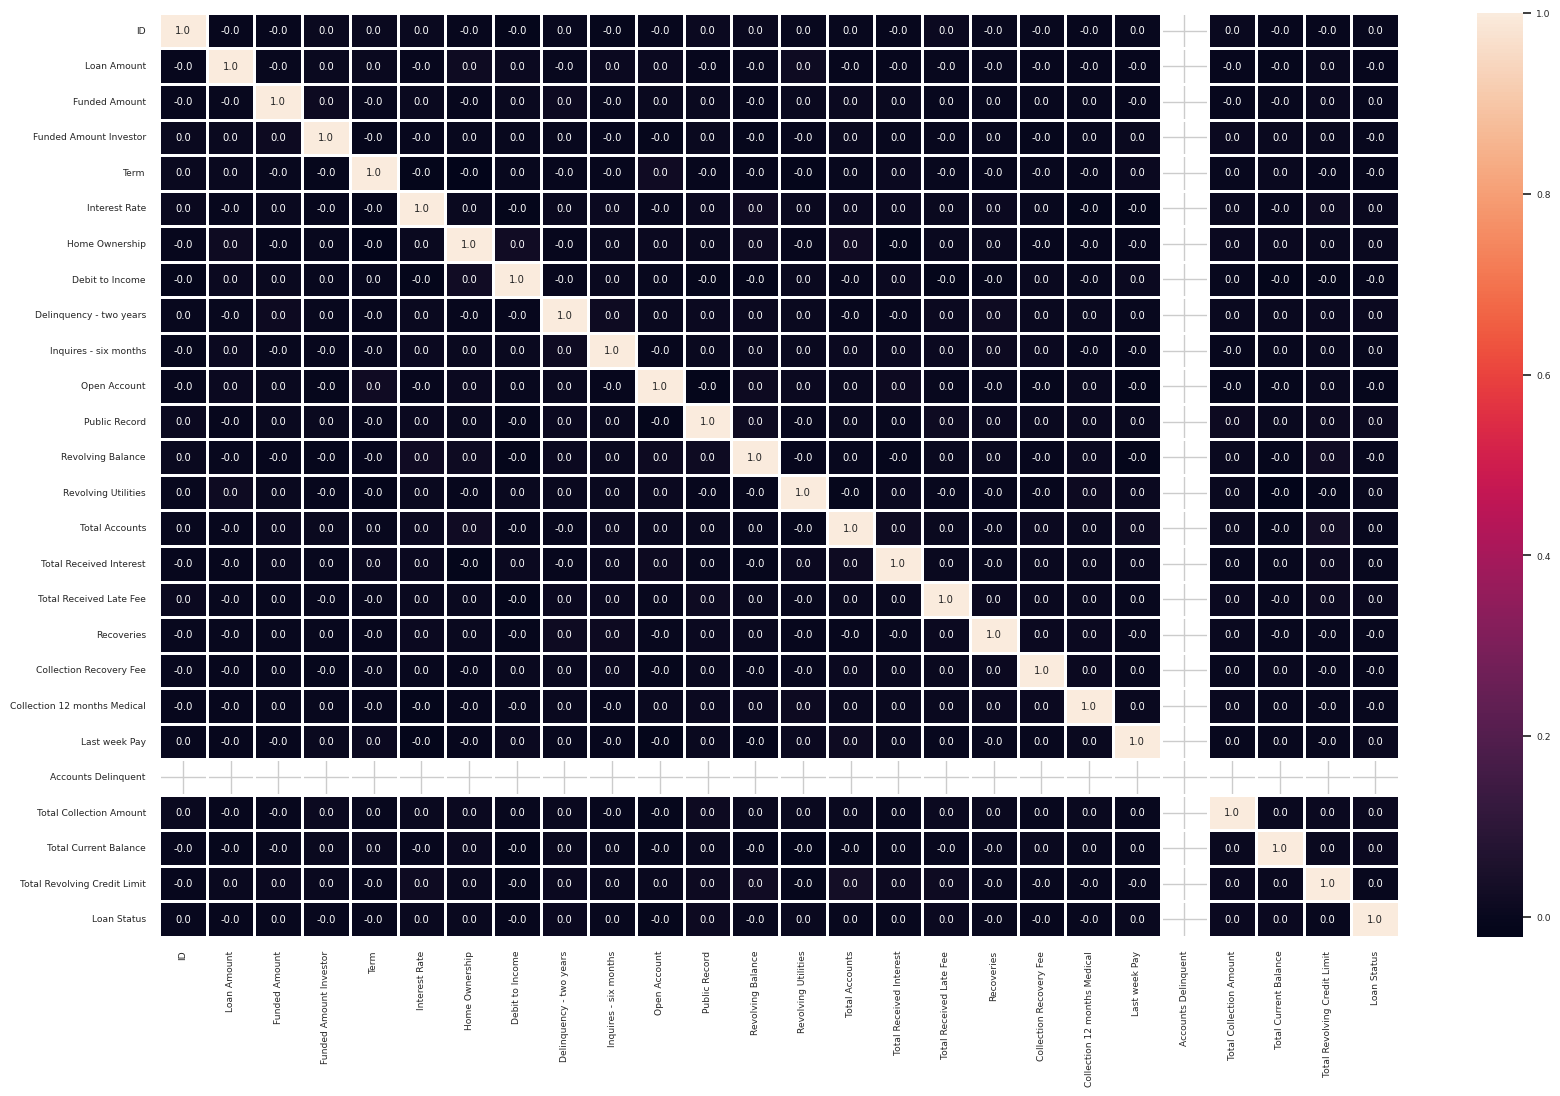

In [ ]:
#Select and analyse important numerical features
corr = train_df.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr,annot=True,linewidths=1,fmt='.1f')

Shows no correlation between features

##Model Building

###Preparing Dataframe for initial model training based on EDA

In [ ]:
train_df

ID  Loan Amount  Funded Amount  Funded Amount Investor  Term  \
0      65087372        10000          32236             12329.36286    59   
1       1450153         3609          11940             12191.99692    59   
2       1969101        28276           9311             21603.22455    59   
3       6651430        11170           6954             17877.15585    59   
4      14354669        16890          13226             13539.92667    59   
...         ...          ...            ...                     ...   ...   
67458  16164945        13601           6848             13175.28583    59   
67459  35182714         8323          11046             15637.46301    59   
67460  16435904        15897          32921             12329.45775    59   
67461   5300325        16567           4975             21353.68465    59   
67462  65443173        15353          29875             14207.44860    59   

      Batch Enrolled  Interest Rate Grade Sub Grade Employment Duration  ...  \
0         BAT2522922      11.135007     B        C4            MORTGAGE  ...   
1         BAT1586599      12.237563     C        D3                RENT  ...   
2         BAT2136391      12.545884     F        D4            MORTGAGE  ...   
3         BAT2428731      16.731201     C        C3            MORTGAGE  ...   
4         BAT5341619      15.008300     C        D4            MORTGAGE  ...   
...              ...            ...   ...       ...                 ...  ...   
67458     BAT3193689       9.408858     C        A4            MORTGAGE  ...   
67459     BAT1780517       9.972104     C        B3                RENT  ...   
67460     BAT1761981      19.650943     A        F3            MORTGAGE  ...   
67461     BAT2333412      13.169095     D        E3                 OWN  ...   
67462     BAT1930365      16.034631     B        D1            MORTGAGE  ...   

        Recoveries Collection Recovery Fee Collection 12 months Medical  \
0         2.498291                0.793724                            0   
1         2.377215                0.974821                            0   
2         4.316277                1.020075                            0   
3         0.107020                0.749971                            0   
4      1294.818751                0.368953                            0   
...            ...                     ...                          ...   
67458   564.614852                0.865230                            0   
67459     2.015494                1.403368                            0   
67460     5.673092                1.607093                            0   
67461     1.157454                0.207608                            0   
67462     1.856480                0.366386                            0   

      Application Type  Last week Pay  Accounts Delinquent  \
0           INDIVIDUAL             49                    0   
1           INDIVIDUAL            109                    0   
2           INDIVIDUAL             66                    0   
3           INDIVIDUAL             39                    0   
4           INDIVIDUAL             18                    0   
...                ...            ...                  ...   
67458       INDIVIDUAL             69                    0   
67459       INDIVIDUAL             14                    0   
67460       INDIVIDUAL            137                    0   
67461       INDIVIDUAL             73                    0   
67462       INDIVIDUAL             54                    0   

       Total Collection Amount  Total Current Balance  \
0                           31                 311301   
1                           53                 182610   
2                           34                  89801   
3                           40                   9189   
4                          430                 126029   
...                        ...                    ...   
67458                       48                 181775   
67459                    

In [ ]:
train_df.columns

Index(['ID', 'Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term',
       'Batch Enrolled', 'Interest Rate', 'Grade', 'Sub Grade',
       'Employment Duration', 'Home Ownership', 'Verification Status',
       'Payment Plan', 'Loan Title', 'Debit to Income',
       'Delinquency - two years', 'Inquires - six months', 'Open Account',
       'Public Record', 'Revolving Balance', 'Revolving Utilities',
       'Total Accounts', 'Initial List Status', 'Total Received Interest',
       'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee',
       'Collection 12 months Medical', 'Application Type', 'Last week Pay',
       'Accounts Delinquent', 'Total Collection Amount',
       'Total Current Balance', 'Total Revolving Credit Limit', 'Loan Status'],
      dtype='object')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Employment Duration           67463 non-null  object 
 10  Home Ownership                67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

In [ ]:
#changing 'Term' to category from numeric
train_df['Term']=train_df['Term'].astype("str")

In [ ]:
#removing some columns as per earlier analysis
train_df_upd = train_df.drop(['ID','Payment Plan','Accounts Delinquent'],axis=1)
train_df_upd = train_df_upd.drop(['Batch Enrolled','Sub Grade', 'Loan Title'],axis=1)
train_df_upd.head(2)

Loan Amount  Funded Amount  Funded Amount Investor Term  Interest Rate  \
0        10000          32236             12329.36286   59      11.135007   
1         3609          11940             12191.99692   59      12.237563   

  Grade Employment Duration  Home Ownership Verification Status  \
0     B            MORTGAGE     176346.6267        Not Verified   
1     C                RENT      39833.9210     Source Verified   

   Debit to Income  ...  Total Received Late Fee  Recoveries  \
0        16.284758  ...                 0.102055    2.498291   
1        15.412409  ...                 0.036181    2.377215   

   Collection Recovery Fee  Collection 12 months Medical  Application Type  \
0                 0.793724                             0        INDIVIDUAL   
1                 0.974821                             0        INDIVIDUAL   

   Last week Pay  Total Collection Amount Total Current Balance  \
0             49                       31                311301   
1            109                       53                182610   

   Total Revolving Credit Limit  Loan Status  
0                          6619            0  
1                         20885            0  

[2 rows x 29 columns]

In [ ]:
rem_cols = train_df_upd.columns

In [ ]:
#unique values in remaining columns
for i in rem_cols:
    print("The no.of unique values in",i,"are: ",train_df_upd.loc[:,i].nunique())

The no.of unique values in Loan Amount are:  27525
The no.of unique values in Funded Amount are:  24548
The no.of unique values in Funded Amount Investor are:  67441
The no.of unique values in Term are:  3
The no.of unique values in Interest Rate are:  67448
The no.of unique values in Grade are:  7
The no.of unique values in Employment Duration are:  3
The no.of unique values in Home Ownership are:  67454
The no.of unique values in Verification Status are:  3
The no.of unique values in Debit to Income are:  67454
The no.of unique values in Delinquency - two years are:  9
The no.of unique values in Inquires - six months are:  6
The no.of unique values in Open Account are:  36
The no.of unique values in Public Record are:  5
The no.of unique values in Revolving Balance are:  20582
The no.of unique values in Revolving Utilities are:  67458
The no.of unique values in Total Accounts are:  69
The no.of unique values in Initial List Status are:  2
The no.of unique values in Total Received Int

In [ ]:
print(f'df shape before: {train_df_upd.shape}')

train_df_upd_enc = pd.get_dummies(train_df_upd)

print(f'df shape after: {train_df_upd_enc.shape}')

df shape before: (67463, 29)
df shape after: (67463, 43)


In [ ]:
train_df_upd_enc

Loan Amount  Funded Amount  Funded Amount Investor  Interest Rate  \
0            10000          32236             12329.36286      11.135007   
1             3609          11940             12191.99692      12.237563   
2            28276           9311             21603.22455      12.545884   
3            11170           6954             17877.15585      16.731201   
4            16890          13226             13539.92667      15.008300   
...            ...            ...                     ...            ...   
67458        13601           6848             13175.28583       9.408858   
67459         8323          11046             15637.46301       9.972104   
67460        15897          32921             12329.45775      19.650943   
67461        16567           4975             21353.68465      13.169095   
67462        15353          29875             14207.44860      16.034631   

       Home Ownership  Debit to Income  Delinquency - two years  \
0        176346.62670        16.284758                        1   
1         39833.92100        15.412409                        0   
2         91506.69105        28.137619                        0   
3        108286.57590        18.043730                        1   
4         44234.82545        17.209886                        1   
...               ...              ...                      ...   
67458     83961.15003        28.105127                        1   
67459     65491.12817        17.694279                        0   
67460     34813.96985        10.295774                        0   
67461     96938.83564         7.614624                        0   
67462    105123.15580        16.052112                        0   

       Inquires - six months  Open Account  Public Record  ...  \
0                          0            13              0  ...   
1                          0            12              0  ...   
2                          0            14              0  ...   
3                          0             7              0  ...   
4                          3            13              1  ...   
...                      ...           ...            ...  ...   
67458                      0            13              0  ...   
67459                      0            12              0  ...   
67460                      0             7              1  ...   
67461                      0            14              0  ...   
67462                      0            30              0  ...   

       Employment Duration_MORTGAGE  Employment Duration_OWN  \
0                                 1                        0   
1                                 0                        0   
2                                 1                        0   
3                                 1                        0   
4                                 1                        0   
...                             ...                      ...   
67458                             1                        0   
67459                             0                        0   
67460                             1                        0   
67461                             0                        1   
67462                             1                        0   

       Employment Duration_RENT  Verification Status_Not Verified  \
0                             0                                 1   
1                             1                                 0   
2                             0                                 0   
3                             0                                 0   
4                             0                                 0   
...                         ...                               ...   
67458                         0                                 0   
67459                         1                                 0   
67460                         0                                 0   
67461                         0      

In [ ]:
#Splitting data into train and test
X = train_df_upd_enc.drop('Loan Status', axis=1)
y = train_df_upd_enc['Loan Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 0.7)

In [ ]:
y_train.value_counts()

0    42842
1     4382
Name: Loan Status, dtype: int64

In [ ]:
y_test.value_counts()

0    18380
1     1859
Name: Loan Status, dtype: int64

In [ ]:
#function to train and check accuracy for few models - decision tree; random forest; kNN; Gaussian NB; and XG Boost
def model_results_compare(X_train, y_train, X_test, y_test):
  dt = DecisionTreeClassifier()
  rf = RandomForestClassifier()
  knn = KNeighborsClassifier()
  gnb = GaussianNB()
  xgb = XGBClassifier()

  model_list = [dt,rf,knn,gnb,xgb]
  model_list_names = ['Decision Tree','Random Forest','K Neighbors Classifier','Gaussian NB','XGBClassifier']
  train_acc = []
  test_acc = []
  test_roc = []
  train_log_loss = []
  test_log_loss = []

  for i in model_list:
      i_model = i.fit(X_train,y_train)
      ypred_train = i_model.predict(X_train)
      ypred_test = i_model.predict(X_test)
      train_acc.append(accuracy_score(y_train,ypred_train))
      test_acc.append(accuracy_score(y_test,ypred_test))
      test_roc.append(roc_auc_score(y_test,ypred_test))

  val = 0
  for i in model_list_names:
    print(f'training accuracy for {i} is {train_acc[val]}')
    print(f'testing accuracy for {i} is {test_acc[val]}')
    print(f'roc_score for {i} is {i} is {test_roc[val]}\n\n')
    val+=1

###Model Iter - 1

In [ ]:
#comparing with initial column list
model_results_compare(X_train, y_train, X_test, y_test)

training accuracy for Decision Tree is 1.0
testing accuracy for Decision Tree is 0.8184198824052572
roc_score for Decision Tree is Decision Tree is 0.5023347582358212


training accuracy for Random Forest is 0.9998941216330679
testing accuracy for Random Forest is 0.9081476357527546
roc_score for Random Forest is Random Forest is 0.5


training accuracy for K Neighbors Classifier is 0.9087751990513299
testing accuracy for K Neighbors Classifier is 0.9022184890557834
roc_score for K Neighbors Classifier is K Neighbors Classifier is 0.4998784403844252


training accuracy for Gaussian NB is 0.900643740470947
testing accuracy for Gaussian NB is 0.9018726221651268
roc_score for Gaussian NB is Gaussian NB is 0.5011385659623712


training accuracy for XGBClassifier is 0.9243816703371167
testing accuracy for XGBClassifier is 0.9071594446365927
roc_score for XGBClassifier is XGBClassifier is 0.499455930359086




###Model Iter - 2

In [ ]:
#removing 'Delinquency - two years', 'Public Record', 'Collection 12 months Medical' from numerical cols

train_df_upd = train_df_upd.drop(['Public Record','Delinquency - two years', 'Collection 12 months Medical'],axis=1)
train_df_upd.head(2)


Loan Amount  Funded Amount  Funded Amount Investor Term  Interest Rate  \
0        10000          32236             12329.36286   59      11.135007   
1         3609          11940             12191.99692   59      12.237563   

  Grade Employment Duration  Home Ownership Verification Status  \
0     B            MORTGAGE     176346.6267        Not Verified   
1     C                RENT      39833.9210     Source Verified   

   Debit to Income  ...  Total Received Interest  Total Received Late Fee  \
0        16.284758  ...              2929.646315                 0.102055   
1        15.412409  ...               772.769385                 0.036181   

   Recoveries  Collection Recovery Fee  Application Type Last week Pay  \
0    2.498291                 0.793724        INDIVIDUAL            49   
1    2.377215                 0.974821        INDIVIDUAL           109   

   Total Collection Amount  Total Current Balance  \
0                       31                 311301   
1                       53                 182610   

   Total Revolving Credit Limit  Loan Status  
0                          6619            0  
1                         20885            0  

[2 rows x 26 columns]

In [ ]:
print(f'df shape before: {train_df_upd.shape}')

train_df_upd_enc = pd.get_dummies(train_df_upd)

print(f'df shape after: {train_df_upd_enc.shape}')

#Splitting data into train and test
X = train_df_upd_enc.drop('Loan Status', axis=1)
y = train_df_upd_enc['Loan Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 0.7)

df shape before: (67463, 26)
df shape after: (67463, 40)


In [ ]:
#comparing with second set of columns
model_results_compare(X_train, y_train, X_test, y_test)

training accuracy for Decision Tree is 1.0
testing accuracy for Decision Tree is 0.8224220564257128
roc_score for Decision Tree is Decision Tree is 0.5021206570277468


training accuracy for Random Forest is 0.9999788243266136
testing accuracy for Random Forest is 0.9081476357527546
roc_score for Random Forest is Random Forest is 0.5


training accuracy for K Neighbors Classifier is 0.9087751990513299
testing accuracy for K Neighbors Classifier is 0.9022184890557834
roc_score for K Neighbors Classifier is K Neighbors Classifier is 0.4998784403844252


training accuracy for Gaussian NB is 0.900643740470947
testing accuracy for Gaussian NB is 0.9018726221651268
roc_score for Gaussian NB is Gaussian NB is 0.5011385659623712


training accuracy for XGBClassifier is 0.9243181433169575
testing accuracy for XGBClassifier is 0.9073570828598251
roc_score for XGBClassifier is XGBClassifier is 0.5000482609380241




###Model Iter - 3

In [ ]:
#removing next set of columns
train_df_upd = train_df_upd.drop(['Debit to Income','Total Accounts'],axis=1)
train_df_upd.head(2)

Loan Amount  Funded Amount  Funded Amount Investor Term  Interest Rate  \
0        10000          32236             12329.36286   59      11.135007   
1         3609          11940             12191.99692   59      12.237563   

  Grade Employment Duration  Home Ownership Verification Status  \
0     B            MORTGAGE     176346.6267        Not Verified   
1     C                RENT      39833.9210     Source Verified   

   Inquires - six months  ...  Total Received Interest  \
0                      0  ...              2929.646315   
1                      0  ...               772.769385   

   Total Received Late Fee  Recoveries Collection Recovery Fee  \
0                 0.102055    2.498291                0.793724   
1                 0.036181    2.377215                0.974821   

   Application Type  Last week Pay  Total Collection Amount  \
0        INDIVIDUAL             49                       31   
1        INDIVIDUAL            109                       53   

   Total Current Balance Total Revolving Credit Limit  Loan Status  
0                 311301                         6619            0  
1                 182610                        20885            0  

[2 rows x 24 columns]

In [ ]:
print(f'df shape before: {train_df_upd.shape}')

train_df_upd_enc = pd.get_dummies(train_df_upd)

print(f'df shape after: {train_df_upd_enc.shape}')

#Splitting data into train and test
X = train_df_upd_enc.drop('Loan Status', axis=1)
y = train_df_upd_enc['Loan Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 0.7)

df shape before: (67463, 24)
df shape after: (67463, 38)


In [ ]:
#comparing with third set of columns
model_results_compare(X_train, y_train, X_test, y_test)

training accuracy for Decision Tree is 1.0
testing accuracy for Decision Tree is 0.8140224319383369
roc_score for Decision Tree is Decision Tree is 0.49314441522317976


training accuracy for Random Forest is 0.9999788243266136
testing accuracy for Random Forest is 0.9081476357527546
roc_score for Random Forest is Random Forest is 0.5


training accuracy for K Neighbors Classifier is 0.9087751990513299
testing accuracy for K Neighbors Classifier is 0.9022184890557834
roc_score for K Neighbors Classifier is K Neighbors Classifier is 0.4998784403844252


training accuracy for Gaussian NB is 0.900643740470947
testing accuracy for Gaussian NB is 0.9019220317209349
roc_score for Gaussian NB is Gaussian NB is 0.5011657694444168


training accuracy for XGBClassifier is 0.9230264272403862
testing accuracy for XGBClassifier is 0.9072088541924008
roc_score for XGBClassifier is XGBClassifier is 0.499966650491887




###Comparison Model Iter 1, 2 & 3

Removing columns isn't helping towards better prediction, considering all columns and moving towards resampling

###Training with Resampling

In [ ]:
#function to train and check accuracy for few models - decision tree; random forest; kNN; Gaussian NB; and XG Boost with resampling
def model_results_compare_resampled(X_train, y_train, X_test, y_test):
  dt = DecisionTreeClassifier()
  rf = RandomForestClassifier()
  knn = KNeighborsClassifier()
  gnb = GaussianNB()
  xgb = XGBClassifier()

  model_list = [dt,rf,knn,gnb,xgb]
  model_list_names = ['Decision Tree','Random Forest','K Neighbors Classifier','Gaussian NB','XGBClassifier']
  train_acc = []
  test_acc = []
  test_roc = []
  train_log_loss = []
  test_log_loss = []

  for i in model_list:
      i_model = i.fit(X_train,y_train)
      ypred_train = i_model.predict(X_train)
      ypred_test = i_model.predict(X_test)
      train_acc.append(accuracy_score(y_train,ypred_train))
      test_acc.append(accuracy_score(y_test,ypred_test))
      test_roc.append(roc_auc_score(y_test,ypred_test))
      train_log_loss.append(log_loss(ypred_train,y_train))
      test_log_loss.append(log_loss(ypred_test,y_test))

  val = 0
  for i in model_list_names:
    print(f'training accuracy for {i} is {train_acc[val]}')
    print(f'testing accuracy for {i} is {test_acc[val]}')
    print(f'roc_score for {i} is {i} is {test_roc[val]}')
    print(f'train_log_loss for {i} is {train_log_loss[val]}')
    print(f'test_log_loss for {i} is {test_log_loss[val]}\n\n')
    val+=1

In [ ]:
#removing columns from analysis
train_df_fl = train_df.drop(['ID','Payment Plan','Accounts Delinquent'],axis=1)
train_df_fl = train_df_fl.drop(['Batch Enrolled','Sub Grade', 'Loan Title'],axis=1)
train_df_fl.head(2)

Loan Amount  Funded Amount  Funded Amount Investor Term  Interest Rate  \
0        10000          32236             12329.36286   59      11.135007   
1         3609          11940             12191.99692   59      12.237563   

  Grade Employment Duration  Home Ownership Verification Status  \
0     B            MORTGAGE     176346.6267        Not Verified   
1     C                RENT      39833.9210     Source Verified   

   Debit to Income  ...  Total Received Late Fee  Recoveries  \
0        16.284758  ...                 0.102055    2.498291   
1        15.412409  ...                 0.036181    2.377215   

   Collection Recovery Fee  Collection 12 months Medical  Application Type  \
0                 0.793724                             0        INDIVIDUAL   
1                 0.974821                             0        INDIVIDUAL   

   Last week Pay  Total Collection Amount Total Current Balance  \
0             49                       31                311301   
1            109                       53                182610   

   Total Revolving Credit Limit  Loan Status  
0                          6619            0  
1                         20885            0  

[2 rows x 29 columns]

In [ ]:
print(f'df shape before: {train_df_fl.shape}')

train_df_fl_enc = pd.get_dummies(train_df_fl)

print(f'df shape after: {train_df_fl_enc.shape}')

#Splitting data into train and test
X = train_df_fl_enc.drop('Loan Status', axis=1)
y = train_df_fl_enc['Loan Status']

print(f'mean of y: {y.mean()}')

#resample
sampler = RandomOverSampler()
X_res,y_res = sampler.fit_resample(X,y)

#print(y_res.mean())
print(f'mean of y after resampling: {y_res.mean()}')

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size = 0.7, random_state=0)

df shape before: (67463, 29)
df shape after: (67463, 43)
mean of y: 0.09250996842713784
mean of y after resampling: 0.5


In [ ]:
#comparing with all columns with resampling
model_results_compare_resampled(X_train, y_train, X_test, y_test)

training accuracy for Decision Tree is 1.0
testing accuracy for Decision Tree is 0.9322698317634889
roc_score for Decision Tree is Decision Tree is 0.9321452286727034
train_log_loss for Decision Tree is 2.2204460492503136e-16
test_log_loss for Decision Tree is 2.4412427079034


training accuracy for Random Forest is 1.0
testing accuracy for Random Forest is 0.9997005498992759
roc_score for Random Forest is Random Forest is 0.999701103200913
train_log_loss for Random Forest is 2.2204460492503136e-16
test_log_loss for Random Forest is 0.010793275637836795


training accuracy for K Neighbors Classifier is 0.8816357484540893
testing accuracy for K Neighbors Classifier is 0.8280611967114935
roc_score for K Neighbors Classifier is K Neighbors Classifier is 0.8277799160897737
train_log_loss for K Neighbors Classifier is 4.266280056383078
test_log_loss for K Neighbors Classifier is 6.197302629870528


training accuracy for Gaussian NB is 0.5084587562711469
testing accuracy for Gaussian NB is 0

Decision Tree, Random Forest and KNN are doing well, however, huge gap in train and test loss confirms overfitting.

Gaussian NB didn't perform well.

On the other hand, XGB roc_auc score is 84% with least gap in train and test loss (least overfitting). Let's try if we can tune hyperparameter of XGB and can get better results.

###Try out new model

###Hyperparameter tuning for best model from resampling

###Testing trained model using best hyperparameters with original dataset

###With Scaling and Resampling
Try scaling on best model with resampling and tuned hyperparameter

##References:

https://www.kaggle.com/datasets/hemanthsai7/loandefault

https://www.kaggle.com/code/inagib21/predicting-loan-default

https://www.kaggle.com/code/kartikanagawadi/loandefault

https://www.kaggle.com/code/nitinshelke123/loan-default-prediction

https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost

https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d

